<a href="https://colab.research.google.com/github/temilaj/IC-GAN-Demo/blob/main/IC_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) Facebook, Inc. and its affiliates.
All rights reserved.

This source code is licensed under the license found in the
LICENSE file in the root directory of this source tree.

# IC-GAN


Official Colab notebook from the paper <b>"Instance-Conditioned GAN"</b> by Arantxa Casanova, Marlène Careil, Jakob Verbeek, Michał Drożdżal, Adriana Romero-Soriano.

This Colab provides the code to generate images with IC-GAN, with the option of further guiding the generation with captions (CLIP). 

Based on the Colab [WanderClip](https://j.mp/wanderclip) by Eyal Gruss [@eyaler](https://twitter.com/eyaler) [eyalgruss.com](https://eyalgruss.com)

Using the work from [our repository](https://github.com/facebookresearch/ic_gan)

https://github.com/openai/CLIP, Copyright (c) 2021 OpenAI

https://github.com/huggingface/pytorch-pretrained-BigGAN, Copyright (c) 2019 Thomas Wolf




In [1]:
#@title Restart after running this cell!

!nvidia-smi -L

import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = "+cu102"
else:
    torch_version_suffix = "+cu111"

!pip install torch==1.8.0{torch_version_suffix} torchvision==0.9.0{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

GPU 0: Tesla K80 (UUID: GPU-b164c73a-2214-ebc0-aca0-aaa8285ca201)
CUDA version: 11.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.6 MB/s eta 0:11:42tcmalloc: large alloc 1147494400 bytes == 0x55c14fe3a000 @  0x7f3013025615 0x55c11606a4cc 0x55c11614a47a 0x55c11606d2ed 0x55c11615ee1d 0x55c1160e0e99 0x55c1160db9ee 0x55c11606ebda 0x55c1160e0d00 0x55c1160db9ee 0x55c11606ebda 0x55c1160dd737 0x55c11615fc66 0x55c1160dcdaf 0x55c11615fc66 0x55c1160dcdaf 0x55c11615fc66 0x55c1160dcdaf 0x55c11606f039 0x55c1160b2409 0x55c11606dc52 0x55c1160e0c25 0x55c1160db9ee 0x55c11606ebda 0x55c1160dd737 0x55c1160db9ee 0x55c11606ebda 0x55c1160dc915 0x55c11606eafa 0x55c1160dcc0d 0x55c1160db9ee
     |█████████████████               | 1055.7 MB 1.4 MB/s eta 0:11:15tcmalloc: large alloc 1434370048 bytes == 0x55c194490000 @  0x7f3013025615 0x55c11606a4cc 0x55c11614a47a 0x55c11606d2ed 0x55c11615ee1d 0x55c1160e0e99 0x55c1160db9ee 0x55c11606ebda 0x

In [1]:
#@title Setup
!git clone https://github.com/facebookresearch/ic_gan.git

%cd /content
# Uncompress required files
!wget https://dl.fbaipublicfiles.com/ic_gan/cc_icgan_biggan_imagenet_res256.tar.gz
!tar -xvf cc_icgan_biggan_imagenet_res256.tar.gz
!wget https://dl.fbaipublicfiles.com/ic_gan/icgan_biggan_imagenet_res256.tar.gz
!tar -xvf icgan_biggan_imagenet_res256.tar.gz
!wget https://dl.fbaipublicfiles.com/ic_gan/stored_instances.tar.gz
!tar -xvf stored_instances.tar.gz

!pip install pytorch-pretrained-biggan

!git clone --depth 1 https://github.com/openai/CLIP
!pip install ftfy
%cd /content/CLIP
import clip
last_clip_model = 'ViT-B/32'
perceptor, preprocess = clip.load(last_clip_model)

import nltk
nltk.download('wordnet')

!pip install cma


Cloning into 'ic_gan'...
remote: Enumerating objects: 233, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 233 (delta 67), reused 174 (delta 42), pack-reused 23
Receiving objects: 100% (233/233), 6.96 MiB | 23.91 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content
--2021-10-13 02:37:25--  https://dl.fbaipublicfiles.com/ic_gan/cc_icgan_biggan_imagenet_res256.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 342709323 (327M) [application/gzip]
Saving to: ‘cc_icgan_biggan_imagenet_res256.tar.gz’

cc_icgan_biggan_ima 100%[===================>] 326.83M  28.3MB/s    in 12s     

2021-10-13 02:37:37 (27.2 MB/s) - ‘cc_icgan_biggan_imagenet_res256.tar.gz’ saved [342709323/342709323]

cc_icgan_biggan_imagene

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 115MiB/s]


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 269 kB 5.4 MB/s 


In [4]:
#@title Prepare functions
from pytorch_pretrained_biggan import BigGAN, convert_to_images, one_hot_from_names, utils

%cd /content/ic_gan/
import sys
import os
sys.path[0] = '/content/ic_gan/inference'
sys.path.insert(1, os.path.join(sys.path[0], ".."))
import torch 

import numpy as np
import torch
import torchvision
import sys
torch.manual_seed(np.random.randint(sys.maxsize))
import imageio
from IPython.display import HTML, Image, clear_output
from PIL import Image as Image_PIL
from scipy.stats import truncnorm, dirichlet
from torch import nn
from nltk.corpus import wordnet as wn
from base64 import b64encode
from time import time
import cma
from cma.sigma_adaptation import CMAAdaptSigmaCSA, CMAAdaptSigmaTPA
import warnings
warnings.simplefilter("ignore", cma.evolution_strategy.InjectionWarning)
import torchvision.transforms as transforms
import inference.utils as inference_utils
import data_utils.utils as data_utils
from BigGAN_PyTorch.BigGAN import Generator as generator
import sklearn.metrics

def replace_to_inplace_relu(model): #saves memory; from https://github.com/minyoungg/pix2latent/blob/master/pix2latent/model/biggan.py
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.ReLU(inplace=False))
        else:
            replace_to_inplace_relu(child)
    return
    
def save(out,name=None, torch_format=True):
  if torch_format:
    with torch.no_grad():
      out = out.cpu().numpy()
  img = convert_to_images(out)[0]
  if name:
    imageio.imwrite(name, np.asarray(img))
  return img

hist = []
def checkin(i, best_ind, total_losses, losses, regs, out, noise=None, emb=None, probs=None):
  global sample_num, hist
  name = None
  if save_every and i%save_every==0:
    name = '/content/output/frame_%05d.jpg'%sample_num
  pil_image = save(out, name)
  vals0 = [sample_num, i, total_losses[best_ind], losses[best_ind], regs[best_ind], np.mean(total_losses), np.mean(losses), np.mean(regs), np.std(total_losses), np.std(losses), np.std(regs)]
  stats = 'sample=%d iter=%d best: total=%.2f cos=%.2f reg=%.3f avg: total=%.2f cos=%.2f reg=%.3f std: total=%.2f cos=%.2f reg=%.3f'%tuple(vals0)
  vals1 = []
  if noise is not None:
    vals1 = [np.mean(noise), np.std(noise)]
    stats += ' noise: avg=%.2f std=%.3f'%tuple(vals1)
  vals2 = []
  if emb is not None:
    vals2 = [emb.mean(),emb.std()]
    stats += ' emb: avg=%.2f std=%.3f'%tuple(vals2)
  elif probs:
    best = probs[best_ind]
    inds = np.argsort(best)[::-1]
    probs = np.array(probs)
    vals2 = [ind2name[inds[0]], best[inds[0]], ind2name[inds[1]], best[inds[1]], ind2name[inds[2]], best[inds[2]], np.sum(probs >= 0.5)/pop_size,np.sum(probs >= 0.3)/pop_size,np.sum(probs >= 0.1)/pop_size]
    stats += ' 1st=%s(%.2f) 2nd=%s(%.2f) 3rd=%s(%.2f) components: >=0.5:%.0f, >=0.3:%.0f, >=0.1:%.0f'%tuple(vals2)
  hist.append(vals0+vals1+vals2)
  if show_every and i%show_every==0:
    clear_output()
    display(pil_image)  
  print(stats)
  sample_num += 1

def load_icgan(experiment_name, root_ = '/content'):
  root = os.path.join(root_, experiment_name)
  config = torch.load("%s/%s.pth" %
                      (root, "state_dict_best0"))['config']

  config["weights_root"] = root_
  config["model_backbone"] = 'biggan'
  config["experiment_name"] = experiment_name
  G, config = inference_utils.load_model_inference(config)
  G.cuda()
  G.eval()
  return G

def get_output(noise_vector, input_label, input_features):  
  if stochastic_truncation: #https://arxiv.org/abs/1702.04782
    with torch.no_grad():
      trunc_indices = noise_vector.abs() > 2*truncation
      size = torch.count_nonzero(trunc_indices).cpu().numpy()
      trunc = truncnorm.rvs(-2*truncation, 2*truncation, size=(1,size)).astype(np.float32)
      noise_vector.data[trunc_indices] = torch.tensor(trunc, requires_grad=requires_grad, device='cuda')
  else:
    noise_vector = noise_vector.clamp(-2*truncation, 2*truncation)
  if input_label is not None:
    input_label = torch.LongTensor(input_label)
  else:
    input_label = None

  out = model(noise_vector, input_label.cuda() if input_label is not None else None, input_features.cuda() if input_features is not None else None)
  
  if channels==1:
    out = out.mean(dim=1, keepdim=True)
    out = out.repeat(1,3,1,1)
  return out

def normality_loss(vec): #https://arxiv.org/abs/1903.00925
    mu2 = vec.mean().square()
    sigma2 = vec.var()
    return mu2+sigma2-torch.log(sigma2)-1
    

def load_generative_model(gen_model, last_gen_model, experiment_name, model):
  # Load generative model
  if gen_model != last_gen_model:
    model = load_icgan(experiment_name, root_ = '/content')
    last_gen_model = gen_model
  return model, last_gen_model

def load_feature_extractor(gen_model, last_feature_extractor, feature_extractor):
  # Load feature extractor to obtain instance features
  feat_ext_name = 'classification' if gen_model == 'cc_icgan' else 'selfsupervised'
  if last_feature_extractor != feat_ext_name:
    if feat_ext_name == 'classification':
      feat_ext_path = ''
    else:
      !curl -L -o /content/swav_pretrained.pth.tar -C - 'https://dl.fbaipublicfiles.com/deepcluster/swav_800ep_pretrain.pth.tar' 
      feat_ext_path = '/content/swav_pretrained.pth.tar'
    last_feature_extractor = feat_ext_name
    feature_extractor = data_utils.load_pretrained_feature_extractor(feat_ext_path, feature_extractor = feat_ext_name)
    feature_extractor.eval()
  return feature_extractor, last_feature_extractor

norm_mean = torch.Tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
norm_std = torch.Tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def preprocess_input_image(input_image_path, size): 
  pil_image = Image_PIL.open(input_image_path).convert('RGB')
  transform_list =  transforms.Compose([data_utils.CenterCropLongEdge(), transforms.Resize((size,size)), transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
  tensor_image = transform_list(pil_image)
  tensor_image = torch.nn.functional.interpolate(tensor_image.unsqueeze(0), 224, mode="bicubic", align_corners=True)
  return tensor_image

def preprocess_generated_image(image): 
  transform_list =  transforms.Normalize(norm_mean, norm_std)
  image = transform_list(image*0.5 + 0.5)
  image = torch.nn.functional.interpolate(image, 224, mode="bicubic", align_corners=True)
  return image

last_gen_model = None
last_feature_extractor = None
model = None
feature_extractor = None

/content/ic_gan


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  108M  100  108M    0     0  22.8M      0  0:00:04  0:00:04 --:--:-- 26.9M
using resnet50 to extract features
Loading pretrained weights from:  /content/swav_pretrained.pth.tar
key  projection_head.0.weight  not in dict
key  projection_head.0.bias  not in dict
key  projection_head.1.weight  not in dict
key  projection_head.1.bias  not in dict
key  projection_head.1.running_mean  not in dict
key  projection_head.1.running_var  not in dict
key  projection_head.1.num_batches_tracked  not in dict
key  projection_head.3.weight  not in dict
key  projection_head.3.bias  not in dict
key  prototypes.weight  not in dict
Network key  fc.weight  not in dict to load
Network key  fc.bias  not in dict to load
Selecting an instance from pre-extracted vectors!
For name best  best0  we have an FID:  22.453704833984375
Checkpoint with name  best

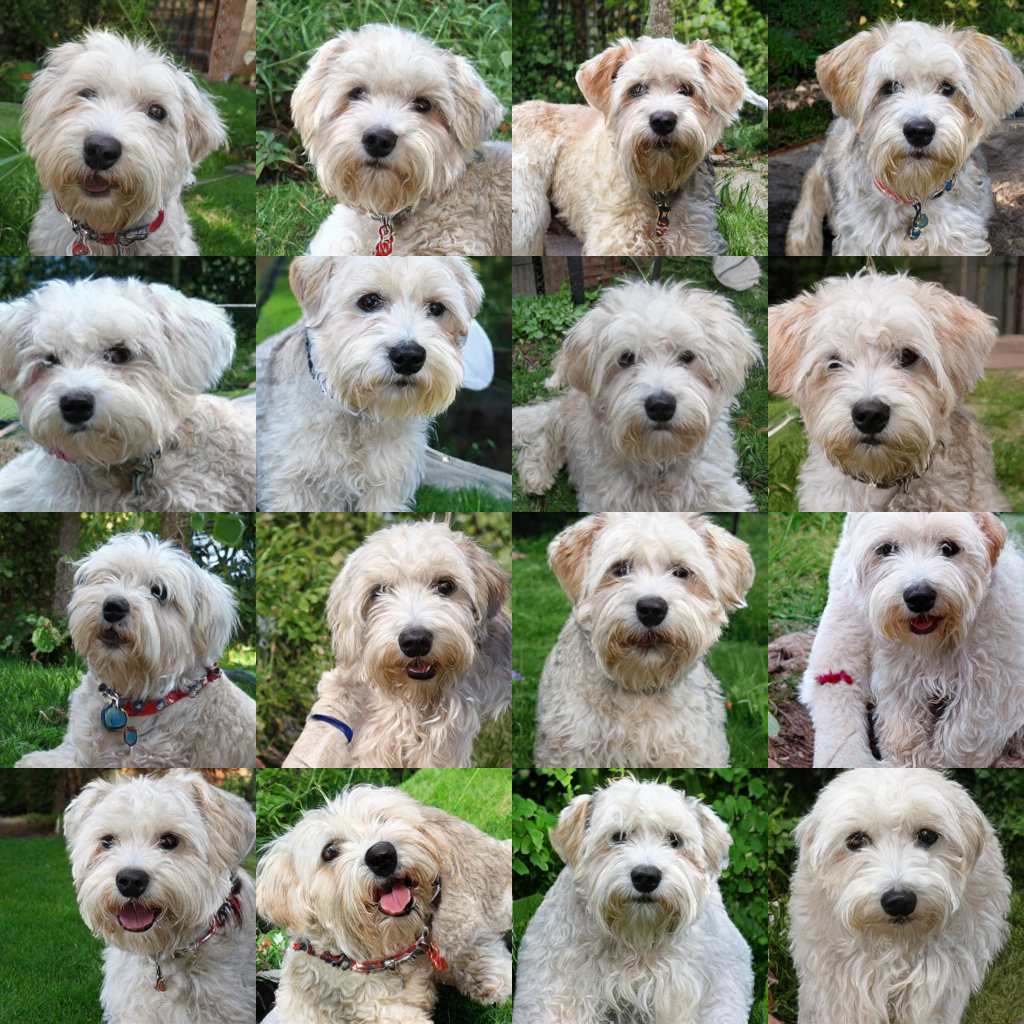

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
#@title Generate images with IC-GAN!
#@markdown 1. Select type of IC-GAN model with **gen_model**: "icgan" is conditioned on an instance; "cc_icgan" is conditioned on both instance and a class index.
#@markdown 1. Select which instance to condition on, following one of the following options:
#@markdown     1. **input_image_instance** is the path to an input image, from either the mounted Google Drive or a manually uploaded image to "Files" (left part of the screen).
#@markdown     1. **input_feature_index** write an integer from 0 to 1000. This will change the instance conditioning and therefore the style and semantics of the generated images. This will select one of the 1000 instance features pre-selected from ImageNet using k-means.
#@markdown 1. For **class_index** (only valid for gen_model="cc_icgan") write an integer from 0 to 1000. This will change the ImageNet class to condition on. Consult [this link](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) for a correspondence between class name and indexes.
#@markdown 1. **num_samples_ranked** (default=16) indicates the number of generated images to output in a mosaic. These generated images are the ones that scored a higher cosine similarity with the conditioning instance, out of **num_samples_total** (default=160) generated samples. Increasing "num_samples_total" will result in higher run times, but more generated images to choose the top "num_samples_ranked" from, and therefore higher chance of better image quality. Reducing "num_samples_total" too much could result in generated images with poorer visual quality. A ratio of 10:1 (num_samples_total:num_samples_ranked) is recommended.
#@markdown 1. Vary **truncation** (default=0.7) from 0 to 1 to apply the [truncation trick](https://arxiv.org/abs/1809.11096). Truncation=1 will provide more diverse but possibly poorer quality images. Trucation values between 0.7 and 0.9 seem to empirically work well.
#@markdown 1. **seed**=0 means no seed.

gen_model = 'icgan' #@param ['icgan', 'cc_icgan']
if gen_model == 'icgan':  
  experiment_name = 'icgan_biggan_imagenet_res256'
else:
  experiment_name = 'cc_icgan_biggan_imagenet_res256'
#last_gen_model = experiment_name
size = '256'
input_image_instance = ""#@param {type:"string"}
input_feature_index =   3#@param {type:'integer'}
class_index =   538#@param {type:'integer'}
num_samples_ranked =   16#@param {type:'integer'}
num_samples_total =    160#@param {type:'integer'}
truncation =  0.7#@param {type:'number'}
stochastic_truncation = False #@param {type:'boolean'}
download_file = True #@param {type:'boolean'}
seed =  50#@param {type:'number'}
if seed == 0:
  seed = None
noise_size = 128
class_size = 1000
channels = 3
batch_size = 4
if gen_model == 'icgan':
  class_index = None
if 'biggan' in gen_model:
  input_feature_index = None
  input_image_instance = None

assert(num_samples_ranked <=num_samples_total)
import numpy as np
state = None if not seed else np.random.RandomState(seed)
np.random.seed(seed)

feature_extractor_name = 'classification' if gen_model == 'cc_icgan' else 'selfsupervised'

# Load feature extractor (outlier filtering and optionally input image feature extraction)
feature_extractor, last_feature_extractor = load_feature_extractor(gen_model, last_feature_extractor, feature_extractor)
# Load features 
if input_image_instance not in ['None', ""]:
  print('Obtaining instance features from input image!')
  input_feature_index = None
  input_image_tensor = preprocess_input_image(input_image_instance, int(size))
  print('Displaying instance conditioning:')
  display(convert_to_images(((input_image_tensor*norm_std + norm_mean)-0.5) / 0.5)[0])
  with torch.no_grad():
    input_features, _ = feature_extractor(input_image_tensor.cuda())
  input_features/=torch.linalg.norm(input_features,dim=-1, keepdims=True)
elif input_feature_index is not None:
  print('Selecting an instance from pre-extracted vectors!')
  input_features = np.load('/content/stored_instances/imagenet_res'+str(size)+'_rn50_'+feature_extractor_name+'_kmeans_k1000_instance_features.npy', allow_pickle=True).item()["instance_features"][input_feature_index:input_feature_index+1]
else:
  input_features = None

# Load generative model
model, last_gen_model = load_generative_model(gen_model, last_gen_model, experiment_name, model)
# Prepare other variables
name_file = '%s_class_index%s_instance_index%s'%(gen_model, str(class_index) if class_index is not None else 'None', str(input_feature_index) if input_feature_index is not None else 'None')

!rm -rf /content/output
!mkdir -p /content/output

replace_to_inplace_relu(model)
ind2name = {index: wn.of2ss('%08dn'%offset).lemma_names()[0] for offset, index in utils.IMAGENET.items()}

from google.colab import files, output

eps = 1e-8

# Create noise, instance and class vector
noise_vector = truncnorm.rvs(-2*truncation, 2*truncation, size=(num_samples_total, noise_size), random_state=state).astype(np.float32) #see https://github.com/tensorflow/hub/issues/214
noise_vector = torch.tensor(noise_vector, requires_grad=False, device='cuda')
if input_features is not None:
  instance_vector = torch.tensor(input_features, requires_grad=False, device='cuda').repeat(num_samples_total, 1)
else: 
  instance_vector = None
if class_index is not None:
  print('Conditioning on class: ', ind2name[class_index])
  input_label = torch.LongTensor([class_index]*num_samples_total)
else:
  input_label = None
if input_feature_index is not None:
  print('Conditioning on instance with index: ', input_feature_index)

size = int(size)
all_outs, all_dists = [], []
for i_bs in range(num_samples_total//batch_size+1):
  start = i_bs*batch_size
  end = min(start+batch_size, num_samples_total)
  if start == end:
    break
  out = get_output(noise_vector[start:end], input_label[start:end] if input_label is not None else None, instance_vector[start:end] if instance_vector is not None else None)

  if instance_vector is not None:
    # Get features from generated images + feature extractor
    out_ = preprocess_generated_image(out)
    with torch.no_grad():
      out_features, _ = feature_extractor(out_.cuda())
    out_features/=torch.linalg.norm(out_features,dim=-1, keepdims=True)
    dists = sklearn.metrics.pairwise_distances(
            out_features.cpu(), instance_vector[start:end].cpu(), metric="euclidean", n_jobs=-1)
    all_dists.append(np.diagonal(dists))
    all_outs.append(out.detach().cpu())
  del (out)
all_outs = torch.cat(all_outs)
all_dists = np.concatenate(all_dists)

# Order samples by distance to conditioning feature vector and select only num_samples_ranked images
selected_idxs =np.argsort(all_dists)[:num_samples_ranked]
#print('All distances re-ordered ', np.sort(all_dists))
# Create figure                
row_i, col_i, i_im = 0, 0, 0
all_images_mosaic = np.zeros((3,size*(int(np.sqrt(num_samples_ranked))), size*(int(np.sqrt(num_samples_ranked)))))
for j in selected_idxs:
  all_images_mosaic[:,row_i*size:row_i*size+size, col_i*size:col_i*size+size] = all_outs[j]
  if row_i == int(np.sqrt(num_samples_ranked))-1:
    row_i = 0
    if col_i == int(np.sqrt(num_samples_ranked))-1:
      col_i = 0
    else:
      col_i +=1
  else:
    row_i+=1
  i_im +=1

name = '/content/%s_seed%i.png'%(name_file,seed if seed is not None else -1)
pil_image = save(all_images_mosaic[np.newaxis,...],name, torch_format=False)  
print('Displaying generated images')
display(pil_image)

if download_file:
  files.download(name)



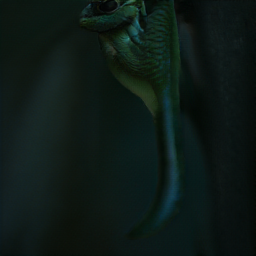

sample=99 iter=99 best: total=71.50 cos=71.50 reg=0.000 avg: total=72.55 cos=72.55 reg=0.000 std: total=0.86 cos=0.86 reg=0.000 noise: avg=-0.02 std=2.069
took: 5896 secs (58.97 sec/iter) on GPU 0: Tesla K80 (UUID: GPU-b164c73a-2214-ebc0-aca0-aaa8285ca201). CUDA memory: 5.8 GB


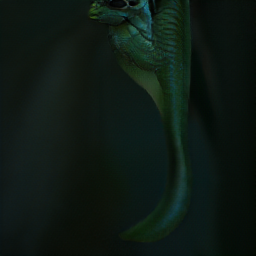

best_loss=71.00 best_iter=95


In [6]:
#@title Generate images with IC-GAN + CLIP!
#@markdown 1. For **prompt** OpenAI suggest to use the template "A photo of a X." or "A photo of a X, a type of Y." [[paper]](https://cdn.openai.com/papers/Learning_Transferable_Visual_Models_From_Natural_Language_Supervision.pdf)
#@markdown 1. Select type of IC-GAN model with **gen_model**: "icgan" is conditioned on an instance; "cc_icgan" is conditioned on both instance and a class index.
#@markdown 1. Select which instance to condition on, following one of the following options:
#@markdown     1. **input_image_instance** is the path to an input image, from either the mounted Google Drive or a manually uploaded image to "Files" (left part of the screen).
#@markdown     1. **input_feature_index** write an integer from 0 to 1000. This will change the instance conditioning and therefore the style and semantics of the generated images. This will select one of the 1000 instance features pre-selected from ImageNet using k-means.
#@markdown 1. For **class_index** (only valid for gen_model="cc_icgan") write an integer from 0 to 1000. This will change the ImageNet class to condition on. Consult [this link](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) for a correspondence between class name and indexes.
#@markdown 1. Vary **truncation** from 0 to 1 to apply the [truncation trick](https://arxiv.org/abs/1809.11096). Truncation=1 will provide more diverse but possibly poorer quality images. Trucation values between 0.7 and 0.9 seem to empirically work well.
#@markdown 4. **seed**=0 means no seed.
prompt = 'A dragon' #@param {type:'string'}
gen_model = 'icgan' #@param ['icgan', 'cc_icgan']
if gen_model == 'icgan':  
  experiment_name = 'icgan_biggan_imagenet_res256'
else:
  experiment_name = 'cc_icgan_biggan_imagenet_res256'
#last_gen_model = experiment_name
size = '256'
input_image_instance = "dragon"#@param {type:"string"}

input_feature_index =   500#@param {type:'integer'}
class_index =  627 #@param {type:'integer'} (only with cc_icgan)
download_image = True #@param {type:'boolean'}
download_video = False #@param {type:'boolean'}
truncation = 0.7 #@param {type:'number'}
stochastic_truncation = False #@param {type:'boolean'}
optimizer = 'CMA-ES' #@param ['SGD','Adam','CMA-ES','CMA-ES + SGD interleaved','CMA-ES + Adam interleaved','CMA-ES + terminal SGD','CMA-ES + terminal Adam']
pop_size = 50 #@param {type:'integer'}
clip_model = 'ViT-B/32' #@param ['ViT-B/32','RN50','RN101','RN50x4']
augmentations =  64#@param {type:'integer'}
learning_rate =  0.1#@param {type:'number'}
noise_normality_loss =  0#@param {type:'number'}
minimum_entropy_loss = 0.0001 #@param {type:'number'}
total_variation_loss = 0.1 #@param {type:'number'}
iterations =  100#@param {type:'integer'}
terminal_iterations =  100#@param {type:'integer'}
show_every = 1 #@param {type:'integer'}
save_every = 1 #@param {type:'integer'}
fps =  2#@param {type:'number'}
freeze_secs = 0 #@param {type:'number'}
seed =  10#@param {type:'number'}
if seed == 0:
  seed = None

softmax_temp = 1
emb_factor = 0.067 #calculated empirically 
loss_factor = 100
sigma0 = 0.5 #http://cma.gforge.inria.fr/cmaes_sourcecode_page.html#practical
cma_adapt = True
cma_diag = False
cma_active = True
cma_elitist = False
noise_size = 128
class_size = 1000
channels = 3
if gen_model == 'icgan':
  class_index = None

import numpy as np
state = None if not seed else np.random.RandomState(seed)
np.random.seed(seed)
# Load features 
if input_image_instance not in ['None',""]:
  print('Obtaining instance features from input image!')
  input_feature_index = None
  feature_extractor, last_feature_extractor = load_feature_extractor(gen_model, last_feature_extractor, feature_extractor)
  input_image_tensor = preprocess_input_image(input_image_instance, int(size))
  input_features, _ = feature_extractor(input_image_tensor.cuda())
  input_features/=torch.linalg.norm(input_features,dim=-1, keepdims=True)
elif input_feature_index is not None:
  print('Selecting an instance from pre-extracted vectors!')
  feature_extractor_name = 'classification' if gen_model == 'cc_icgan' else 'selfsupervised'
  input_features = np.load('/content/stored_instances/imagenet_res'+str(size)+'_rn50_'+feature_extractor_name+'_kmeans_k1000_instance_features.npy', allow_pickle=True).item()["instance_features"][input_feature_index:input_feature_index+1]
else:
  input_features = None


# Load generative model
model, last_gen_model = load_generative_model(gen_model, last_gen_model, experiment_name, model)

# Load CLIP model
if clip_model != last_clip_model:
  perceptor, preprocess = clip.load(clip_model)
  last_clip_model = clip_model
clip_res = perceptor.visual.input_resolution
sideX = sideY = int(size)
if sideX<=clip_res and sideY<=clip_res:
  augmentations = 1
if 'CMA' not in optimizer:
  pop_size = 1

# Prepare other variables
name_file = '%s_%s_class_index%s_instance_index%s'%(gen_model, prompt, str(class_index) if class_index is not None else 'None', str(input_feature_index) if input_feature_index is not None else 'None')
requires_grad = ('SGD' in optimizer or 'Adam' in optimizer) and ('terminal' not in optimizer or terminal_iterations>0)
total_iterations = iterations + terminal_iterations*('terminal' in optimizer)

!rm -rf /content/output
!mkdir -p /content/output

replace_to_inplace_relu(model)
replace_to_inplace_relu(perceptor)
ind2name = {index: wn.of2ss('%08dn'%offset).lemma_names()[0] for offset, index in utils.IMAGENET.items()}
eps = 1e-8

# Create noise and instance vector
noise_vector = truncnorm.rvs(-2*truncation, 2*truncation, size=(pop_size, noise_size), random_state=state).astype(np.float32) #see https://github.com/tensorflow/hub/issues/214
noise_vector = torch.tensor(noise_vector, requires_grad=requires_grad, device='cuda')
if input_features is not None:
  instance_vector = torch.tensor(input_features, requires_grad=False, device='cuda')
else: 
  instance_vector = None
if class_index is not None:
  print('Conditioning on class: ', ind2name[class_index])
if input_feature_index is not None:
  print('Conditioning on instance with index: ', input_feature_index)

# Prepare optimizer
if requires_grad:
  params = [noise_vector]
  if 'SGD' in optimizer:
    optim = torch.optim.SGD(params, lr=learning_rate, momentum=0.9)  
  else:
    optim = torch.optim.Adam(params, lr=learning_rate)

def ascend_txt(i, grad_step=False, show_save=False):
  global global_best_loss, global_best_iteration, global_best_noise_vector, global_best_class_vector
  regs = []
  losses = []
  total_losses = []
  best_loss = np.inf
  global_reg = torch.tensor(0, device='cuda', dtype=torch.float32, requires_grad=grad_step)
  if noise_normality_loss:
    global_reg = global_reg+noise_normality_loss*normality_loss(noise_vector)
  global_reg = loss_factor*global_reg  
  if grad_step:
    global_reg.backward()
  for j in range(pop_size):
    p_s = []
    out = get_output(noise_vector[j:j+1], [class_index] if class_index is not None else None, instance_vector)
    for aug in range(augmentations):
      if sideX<=clip_res and sideY<=clip_res or augmentations==1:
        apper = out  
      else:
        size = torch.randint(int(.7*sideX), int(.98*sideX), ())
        offsetx = torch.randint(0, sideX - size, ())
        offsety = torch.randint(0, sideX - size, ())
        apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
      apper = (apper+1)/2
      apper = nn.functional.interpolate(apper, clip_res, mode='bilinear')
      #apper = apper.clamp(0,1)
      p_s.append(apper)
    into = nom(torch.cat(p_s, 0))
    predict_clip = perceptor.encode_image(into)
    loss = loss_factor*(1-torch.cosine_similarity(predict_clip, target_clip).mean())
    total_loss = loss
    regs.append(global_reg.item())

    with torch.no_grad():
      losses.append(loss.item())
      total_losses.append(total_loss.item()+global_reg.item())
    if total_losses[-1]<best_loss:
      best_loss = total_losses[-1]
      best_ind = j
      best_out = out
      if best_loss < global_best_loss:
        global_best_loss = best_loss
        global_best_iteration = i
        with torch.no_grad():
          global_best_noise_vector = noise_vector[best_ind]
    if grad_step:    
      total_loss.backward()

  if grad_step:
    optim.step()
    optim.zero_grad()

  if show_save and (save_every and i % save_every == 0 or show_every and i % show_every == 0):
    noise = None
    emb = None
    with torch.no_grad():
      noise = noise_vector.cpu().numpy()
    checkin(i, best_ind, total_losses, losses, regs, best_out, noise, emb)  
  return total_losses, best_ind

# Obtain target CLIP representation
tx = clip.tokenize(prompt)
with torch.no_grad():
  target_clip = perceptor.encode_text(tx.cuda())


global_best_loss = np.inf
global_best_iteration = 0
global_best_noise_vector = None

nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
if 'CMA' in optimizer:
  initial_vector = np.zeros(noise_size)
  bounds = None
  cma_opts = {'popsize': pop_size, 'seed': np.nan, 'AdaptSigma': cma_adapt, 'CMA_diagonal': cma_diag, 'CMA_active': cma_active, 'CMA_elitist':cma_elitist, 'bounds':bounds}
  cmaes = cma.CMAEvolutionStrategy(initial_vector, sigma0, inopts=cma_opts)

sample_num = 0
machine = !nvidia-smi -L
start = time()

# Start noise vector optimization
for i in range(total_iterations):    
  if 'CMA' in optimizer and i<iterations:
    with torch.no_grad():
      cma_results = torch.tensor(cmaes.ask(), dtype=torch.float32).cuda()
      noise_vector.data = cma_results      
  if requires_grad and ('terminal' not in optimizer or i>=iterations):
    losses, best_ind = ascend_txt(i, grad_step=True, show_save='CMA' not in optimizer or i>=iterations)
    assert noise_vector.requires_grad and noise_vector.is_leaf and (not optimize_class or class_vector.requires_grad and class_vector.is_leaf), (noise_vector.requires_grad, noise_vector.is_leaf, class_vector.requires_grad, class_vector.is_leaf)
  if 'CMA' in optimizer and i<iterations:
    with torch.no_grad():
      losses, best_ind = ascend_txt(i, show_save=True)
      if i<iterations-1:
        vectors = noise_vector
        cmaes.tell(vectors.cpu().numpy(), losses)
      elif 'terminal' in optimizer and terminal_iterations:
        pop_size = 1
        noise_vector[0] = global_best_noise_vector
  if save_every and i % save_every == 0 or show_every and i % show_every == 0:
    print('took: %d secs (%.2f sec/iter) on %s. CUDA memory: %.1f GB'%(time()-start,(time()-start)/(i+1), machine[0], torch.cuda.max_memory_allocated()/1024**3))

# Obtain generated image with lowest loss.
out = get_output(global_best_noise_vector.unsqueeze(0), [class_index] if class_index is not None else None, instance_vector)
name = '/content/%s_best_seed%i.png'%(name_file,seed if seed is not None else -1)
pil_image = save(out,name)  
display(pil_image)  
print('best_loss=%.2f best_iter=%d'%(global_best_loss,global_best_iteration))

if download_image:
  from google.colab import files, output
  files.download(name)

if download_video:
  out = '"/content/%s_seed%i.mp4"'%(name_file, seed if seed is not None else -1)
  file_name = '/content/%s_seed%i.mp4'%(name_file, seed if seed is not None else -1)

  with open('/content/list.txt','w') as f:
    for i in range(sample_num):
      f.write('file /content/output/frame_%05d.jpg\n'%i)
    for j in range(int(freeze_secs*fps)):
      f.write('file /content/output/frame_%05d.jpg\n'%i)
  !ffmpeg -r $fps -f concat -safe 0 -i /content/list.txt -c:v libx264 -pix_fmt yuv420p -profile:v baseline -movflags +faststart -r $fps $out -y
  with open(file_name, 'rb') as f:
    data_url = "data:video/mp4;base64," + b64encode(f.read()).decode()
  display(HTML("""
    <video controls autoplay loop>
          <source src="%s" type="video/mp4">
    </video>""" % data_url))

  from google.colab import files, output
  output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')
  files.download(file_name)

In [7]:
!zip -r /content/output.zip /content/output

  adding: content/output/ (stored 0%)
  adding: content/output/frame_00054.jpg (deflated 4%)
  adding: content/output/frame_00013.jpg (deflated 2%)
  adding: content/output/frame_00067.jpg (deflated 6%)
  adding: content/output/frame_00094.jpg (deflated 7%)
  adding: content/output/frame_00046.jpg (deflated 4%)
  adding: content/output/frame_00052.jpg (deflated 4%)
  adding: content/output/frame_00055.jpg (deflated 4%)
  adding: content/output/frame_00019.jpg (deflated 2%)
  adding: content/output/frame_00045.jpg (deflated 3%)
  adding: content/output/frame_00096.jpg (deflated 7%)
  adding: content/output/frame_00065.jpg (deflated 5%)
  adding: content/output/frame_00028.jpg (deflated 3%)
  adding: content/output/frame_00050.jpg (deflated 5%)
  adding: content/output/frame_00027.jpg (deflated 2%)
  adding: content/output/frame_00073.jpg (deflated 6%)
  adding: content/output/frame_00071.jpg (deflated 6%)
  adding: content/output/frame_00031.jpg (deflated 3%)
  adding: content/output/fr

In [8]:
from google.colab import files
files.download("/content/output.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>